# Анализ сервиса аренды самокатов

### Описание проекта

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках из популярного сервиса аренды самокатов GoFast. 
Необходимо проанализировать данные и проверить следующие гипотезы, которые могут помочь бизнесу вырасти:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
оптимального с точки зрения износа самоката?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Также у нас есть данные о подписках с стоимости поездок:
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
  * абонентская плата — 199 рублей в месяц;
  * стоимость одной минуты поездки — 6 рублей;
  * стоимость старта — бесплатно.

### План исследования

- Чтение анных
- Обработка пропущенных и ошибочных значений, дубликатов, создание новых столбцов, изменение типов данных
- Изучение информации о пользователях, поездках, выручке
- Построение и проверка гипотез
- Решение задач отдела маркетинга

### Описание данных

Пользователи — users_go.csv
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

Поездки — rides_go.csv

- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

Подписки — subscriptions_go.csv

- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

### Импорт необходимых библиотек

In [20]:
# Установим недостающие библиотеки
!pip install missingno


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [21]:
# Импортируем необходимые библиотеки
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
pd.set_option('display.float_format', '{:,.2f}'.format)

## Шаг 1. Загрузка данных

### Чтение данных

In [22]:
# Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы.
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subs = pd.read_csv('subscriptions_go.csv')

In [23]:
# Проверим размеры получившихся датасетов
print(users.shape)
print(rides.shape)
print(subs.shape)

(1565, 5)
(18068, 4)
(2, 4)


### Изучение общей информации о датафреймах

In [24]:
# Посмотрим первые строки датасета users
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [25]:
# Посмотрим информацию о датасете users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [26]:
# Посмотрим первые строки датасета rides
rides.head()

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


In [27]:
# Посмотрим информацию о датасете rides
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [28]:
# Посмотрим первые строки датасета head
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [29]:
# Посмотрим первые строки датасета info
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


По инофрмации о подписках график строить нет смысла т.к. у нас всего 2 строки.

### Вывод

Проведенная работа:

- Открыли файлы с данными и сохранили их в отдельные переменные
- Посмотрели типы данных в датасетах
- Построили предварительные графики числовых признаков

Результаты анализа, проблемы и решения:

С первого взляда моджно сказать что в датасете есть проблема с типом данных в столбце date датасета с поездками. В данных похоже нет пропущенных значений и явных выбросов. По графикам можно сказать что числовые признаки распределены нормально.

## Шаг 2. Предобработка данных

### Изменение типов данных

In [30]:
# Изменим тип данных столбца date
rides['date'] = pd.to_datetime(rides['date'])

In [31]:
# Проверим тип данных столбца date из датасета rides
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Создание новых столбцов

In [32]:
# Cоздадим новый стобец с номером месяца из столбца date датасета rides
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [33]:
# Посмотрим за какой перод данные
rides['date'].max() - rides['date'].min()

Timedelta('363 days 00:00:00')

Представлены данные за год

In [34]:
# Проверим что все получилось
rides.head()

,user_id,distance,duration,date,month
0,1,"4,409.92",25.60,2021-01-01,1
1,1,"2,617.59",15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,"2,694.78",18.51,2021-08-11,8
4,1,"4,028.69",26.27,2021-08-28,8


### Проверка и обработка пропущенных значений и дубликатов

In [35]:
# Посмотрим есть ли в датасетах пропущенные значения
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [36]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [37]:
subs.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенных значений нет

In [38]:
# Посмотрим общее количество явных дубликатов в датасетах
users.duplicated().sum()

31

In [39]:
rides.duplicated().sum()

0

In [40]:
subs.duplicated().sum()

0

Нашли 31 дубликат в датасете users

In [41]:
# Проведем контроль размеров датасета до и после преобразования
temp_users = users.copy()
len(temp_users)

1565

In [42]:
# Избавимся от явных дубликатов в датасете users
users = users.drop_duplicates()

In [43]:
# Проверим что явных дубликатов в датасете больше нет
users.duplicated().sum()

0

In [44]:
# Проведем контроль размеров датасета до и после преобразования
print(len(temp_users))
print(len(users))

1565
1534


Удалили 31 дубликат

In [45]:
# Посмотрим количество уникальных значений в датасете users
users.nunique()

user_id              1534
name                  194
age                    29
city                    8
subscription_type       2
dtype: int64

В столбце users_id все значения уникальны

In [46]:
# Рассмотрим уникальные значения в столбце name
print(list(users['name'].unique()))

['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина', 'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева', 'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор', 'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий', 'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван', 'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина', 'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений', 'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса', 'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия', 'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур', 'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав', 'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей', 'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан', 'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей', 'Альбина', 'Людмила', 'Марсель', 'Милена', 'Диана', 'Дарина', 'Данил', 'Артемий', 'Лиана', 'Альберт', 'Герм

In [47]:
# Рассмотрим уникальные значения в столбце age
print(list(users['age'].unique()))

[22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17, 12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43]


In [48]:
# Рассмотрим уникальные значения в столбце age
print(list(users['city'].unique()))

['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар', 'Пятигорск', 'Екатеринбург', 'Сочи']


In [49]:
# Рассмотрим уникальные значения в столбце subscription_type
print(list(users['subscription_type'].unique()))

['ultra', 'free']


Неявных дубликатов в датасете users не замечено

In [50]:
# Посмотрим количество уникальных значений в датасете users
rides.nunique()

user_id      1534
distance    18068
duration    17974
date          364
month          12
dtype: int64

In [51]:
# Рассмотрим уникальные значения в столбце month
print(list(rides['month'].unique()))

[1, 4, 8, 10, 11, 12, 3, 6, 7, 2, 5, 9]


В датасете rides количество униакальных user_id равно тому же количесву в датасете users. Дубликатов в месяцах нет.

In [52]:
# Посмотрим количество уникальных значений в датасете users
subs.nunique()

subscription_type    2
minute_price         2
start_ride_price     2
subscription_fee     2
dtype: int64

В датасете с подписками у нас всего 2 строки. Дубликатов нет.

### Вывод

Проведенная работа:

- Проверили пропуски
- Проверили явные и неявные дубликаты

Результаты анализа, проблемы и решения:

Пропусков в датасетах не обнаружено. Были найдены и удалены явные дубликаты в датасете users. Неявных дубликатов также не было ни в одном датасете.

## Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

### Частота встречаемости городов

In [53]:
# Построим сводную таблицу частоты встречаемости городов
users.pivot_table(index='city', values='name', aggfunc=['count']).sort_values(by=('count', 'name'),ascending=False)

,count
,name
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [54]:
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

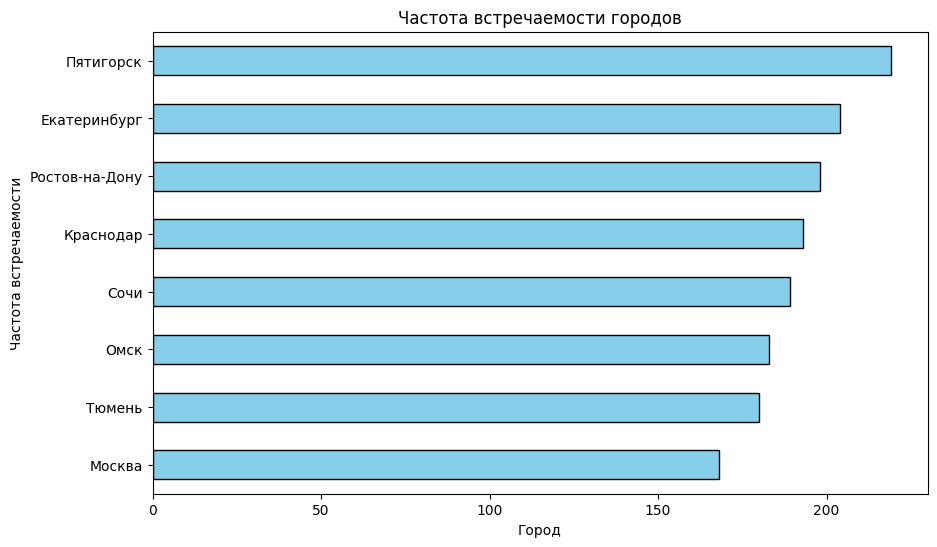

In [55]:
# Построим график частоты встречаемости городов
users.pivot_table(index='city', values='name', aggfunc=['count']).sort_values(by=('count', 'name'), ascending=True).plot(kind='barh', legend=False, figsize=(10, 6), edgecolor='black', color='skyblue')
plt.title('Частота встречаемости городов')
plt.ylabel('Частота встречаемости')
plt.xlabel('Город')
plt.show()

Больше всего пользователей пользовались сервисом в Пятигорске, меньше всего в Москве.

### Cоотношение пользователей с подпиской и без подписки

In [56]:
# Посмотрим долю пользователей с подпиской и без
users.groupby('subscription_type').size() / len(users)

subscription_type
free    0.54
ultra   0.46
dtype: float64

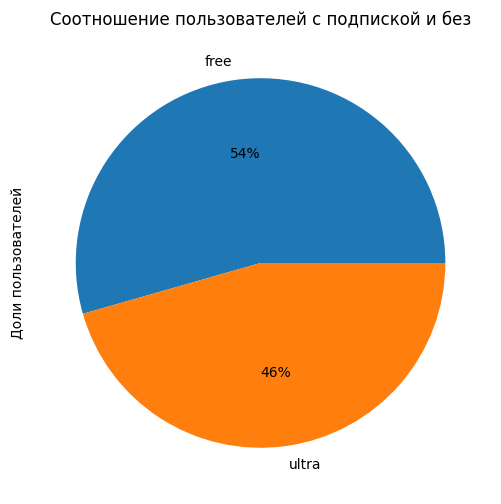

In [57]:
# Построим график долей пользователей с подпиской и без
(users.groupby('subscription_type').size() / len(users)).plot(kind='pie', legend=False, figsize=(10, 6), autopct='%1.0f%%')
plt.title('Соотношение пользователей с подпиской и без')
plt.ylabel('Доли пользователей')
plt.show()

54% людей пользуются бесплатной подпиской, остальные платной

### Возраст пользователей

In [58]:
# Построим сводную таблицу количества пользователей в зависимости от возраста
users.pivot_table(index='age', values='name', aggfunc=['count']).sort_values(by=('age'),ascending=True)

,count
,name
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,47


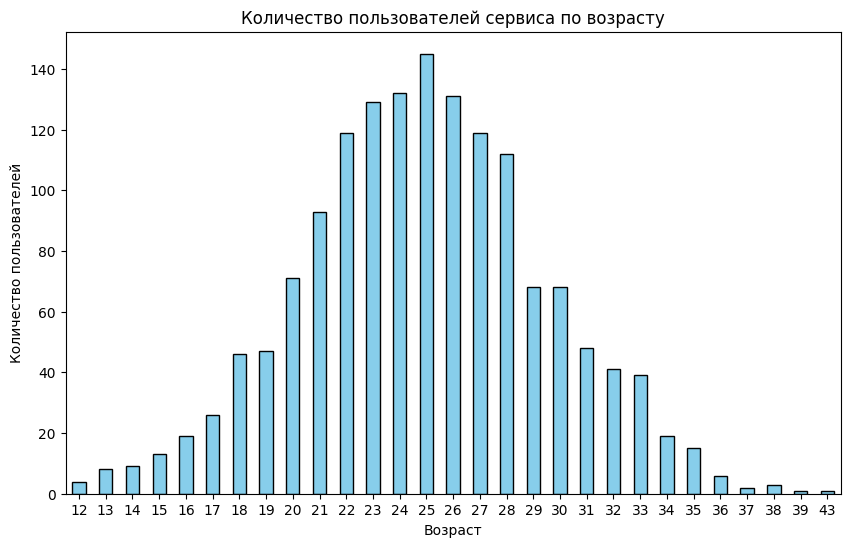

In [59]:
# Построим график количества пользователей по возрасту
users.pivot_table(index='age', values='name', aggfunc=['count']).sort_values(by=('age'), ascending=True).plot(kind='bar', legend=False, figsize=(10, 6), edgecolor='black', color='skyblue')
plt.title('Количество пользователей сервиса по возрасту')
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.xticks(rotation=0)
plt.show()

Пользователи сервиса - это восновном молодые люди 20-30 лет.

### Расстояние, которое пользователь преодолел за одну поездку

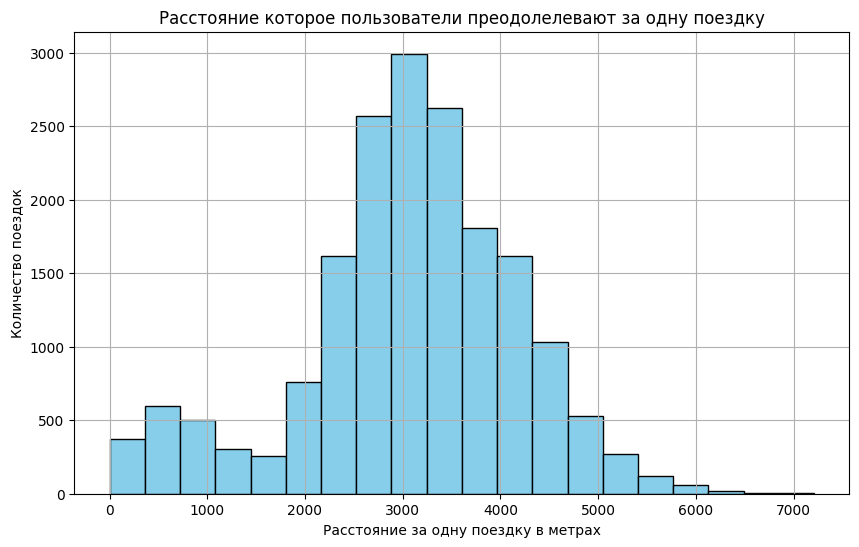

In [60]:
# Построим график зависимости пройденного растояния за одну поездку от количесва поездок
rides['distance'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.title('Расстояние которое пользователи преодолелевают за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние за одну поездку в метрах')
plt.show()

Большая часть пользователей совершает поездки на расстояние от 2 до 5 км.

### Продолжительность поездок

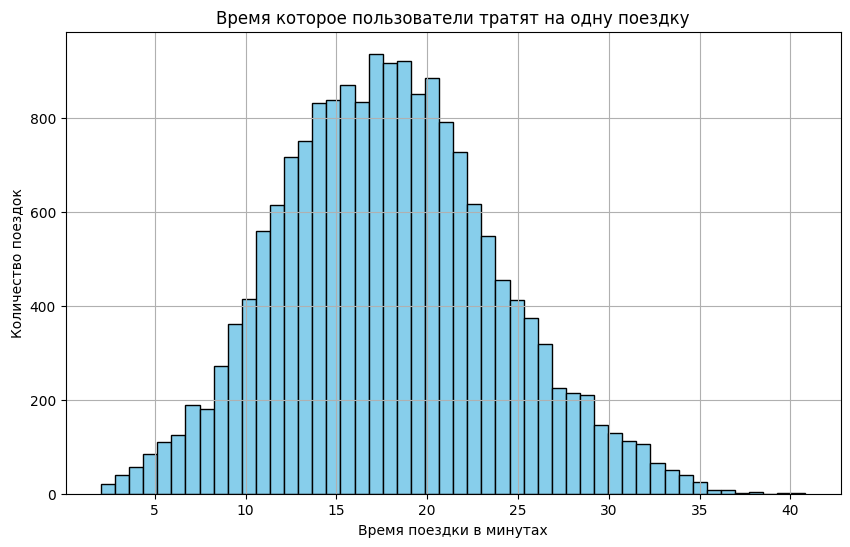

In [61]:
# Построим график зависимости пройденного растояния за одну поездку от количесва поездок
rides[rides['duration']>0.5]['duration'].hist(figsize=(10, 6), bins=50, edgecolor='black', color='skyblue')
plt.title('Время которое пользователи тратят на одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Время поездки в минутах')
plt.show()

Пользователи чаще всего тратят на поездку от 7 до 27 минут.

### Средняя скорость движения

In [62]:
# Создадим столбец со средней скоростью движения в км/ч
rides['speed'] = (rides['distance'] / 1000) / (rides['duration'] / 60)

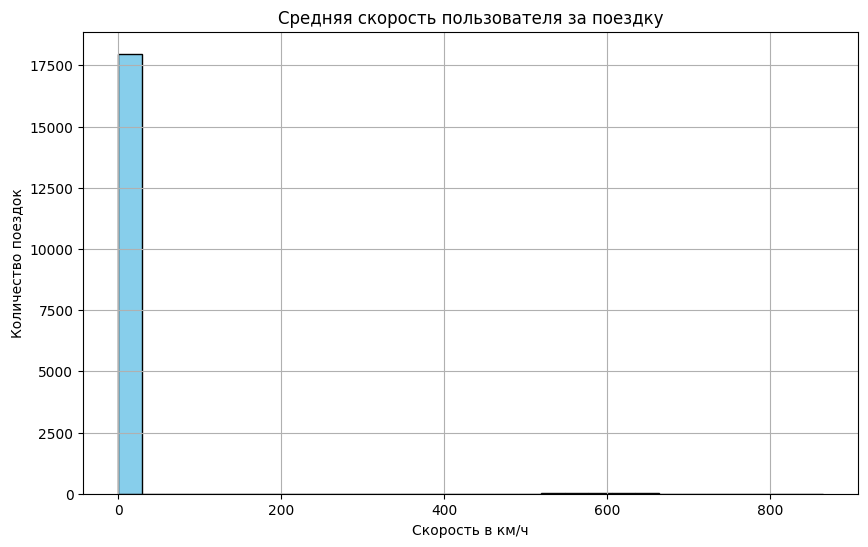

In [63]:
# Построим график зависимости средней скорости за одну поездку от количесва поездок
rides['speed'].hist(figsize=(10, 6), bins=30, edgecolor='black', color='skyblue')
plt.title('Средняя скорость пользователя за поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Скорость в км/ч')
plt.show()

Видно что у нас есть ошибка в данных, на самокате нельзя двигаться с такой скоростью

In [64]:
# Проверим данные со скоростью более 25 км/ч
rides[rides['speed']>25]

,user_id,distance,duration,date,month,speed
6531,701,"4,196.45",0.50,2021-08-31,8,503.57
6570,704,"4,830.82",0.50,2021-10-14,10,579.70
6680,712,"4,684.00",0.50,2021-03-04,3,562.08
6695,713,"5,215.64",0.50,2021-02-25,2,625.88
6768,718,"5,197.44",0.50,2021-02-11,2,623.69
...,...,...,...,...,...,...
17004,1460,"5,531.34",0.50,2021-01-19,1,663.76
17242,1477,"6,724.93",0.50,2021-01-12,1,806.99
17314,1483,"4,445.48",0.50,2021-03-06,3,533.46
17505,1496,"5,722.55",0.50,2021-02-14,2,686.71


Как можно судить по получившейся таблице, проблема с продолжительностью поездки 0.5 минуты. Таких строк не много, не будем отображать их на графиках продолждительности поездки и скорости.

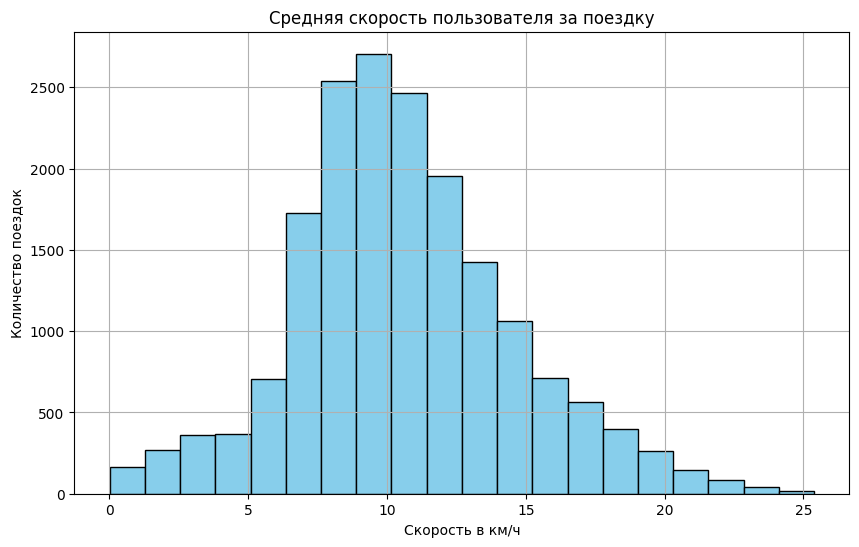

In [65]:
# Построим график зависимости средней скорости за одну поездку от количесва поездок
rides[rides['duration']>0.5]['speed'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.title('Средняя скорость пользователя за поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Скорость в км/ч')
plt.show()

Теперь у нас получился график со средней скоростью от 5 до 20 км/ч.

### Вывод

Проведенная работа:

Построены графики следующих признаков, проведен их анализ:
- Частота встречаемости городов
- Cоотношение пользователей с подпиской и без подписки
- Возраст пользователей
- Расстояние, которое пользователь преодолел за одну поездку
- Продолжительность поездок
- Средняя скорость движения


Результаты анализа, проблемы и решения:

Больше всего пользователей пользовались сервисом в Пятигорске, меньше всего в Москве. 54% людей пользуются бесплатной подпиской, остальные платной. Пользователи сервиса - это восновном молодые люди 20-30 лет. Большая часть пользователей совершает поездки на расстояние от 2 до 5 км. Пользователи чаще всего тратят на поездку от 7 до 27 минут. Cредняя скорость за поездку - от 5 до 20 км/ч.

## Шаг 4. Объединение данных

### Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [66]:
# Объединим датафреймы users и subs
df = users.merge(subs, on='subscription_type')

In [67]:
# Посмотрим информацию о получившемся датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
 5   minute_price       1534 non-null   int64 
 6   start_ride_price   1534 non-null   int64 
 7   subscription_fee   1534 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 96.0+ KB


In [68]:
# Объединим датафреймы rides и ранее объединенный датафрейм
df = rides.merge(df, on='user_id')

In [69]:
# Округлим значение продолжительности поездик до целого
df['duration'] = np.ceil(df['duration'])

In [70]:
# Посмотрим информацию о получившемся датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   speed              18068 non-null  float64       
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   subscription_type  18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(

Датафреймы с данными о пользователях, поездках и подписках объединены.

### Создание новых датафреймов

Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

In [71]:
# Создадим датафрейм с пользователями с подпиской
ultra = df[df['subscription_type'] == 'ultra']

In [72]:
# Посмотрим первые строки получившегося датафрейма
ultra.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,"4,409.92",26.00,2021-01-01,1,10.34,Кира,22,Тюмень,ultra,6,0,199
1,1,"2,617.59",16.00,2021-01-18,1,9.93,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7.00,2021-04-20,4,7.26,Кира,22,Тюмень,ultra,6,0,199
3,1,"2,694.78",19.00,2021-08-11,8,8.73,Кира,22,Тюмень,ultra,6,0,199
4,1,"4,028.69",27.00,2021-08-28,8,9.20,Кира,22,Тюмень,ultra,6,0,199


In [73]:
ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int32         
 5   speed              6500 non-null   float64       
 6   name               6500 non-null   object        
 7   age                6500 non-null   int64         
 8   city               6500 non-null   object        
 9   subscription_type  6500 non-null   object        
 10  minute_price       6500 non-null   int64         
 11  start_ride_price   6500 non-null   int64         
 12  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(3)
memo

In [74]:
# Создадим датафрейм с пользователями без подписки
free = df[df['subscription_type'] == 'free']

In [75]:
# Посмотрим первые строки получившегося датафрема
free.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,"2,515.69",15.00,2021-01-02,1,10.10,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17.00,2021-02-01,2,3.13,Айдар,22,Омск,free,8,50,0
6502,700,"4,004.43",21.00,2021-02-04,2,12.00,Айдар,22,Омск,free,8,50,0
6503,700,"1,205.91",10.00,2021-02-10,2,7.40,Айдар,22,Омск,free,8,50,0
6504,700,"3,047.38",18.00,2021-02-14,2,10.49,Айдар,22,Омск,free,8,50,0


In [76]:
free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int32         
 5   speed              11568 non-null  float64       
 6   name               11568 non-null  object        
 7   age                11568 non-null  int64         
 8   city               11568 non-null  object        
 9   subscription_type  11568 non-null  object        
 10  minute_price       11568 non-null  int64         
 11  start_ride_price   11568 non-null  int64         
 12  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(3)

Создали датафреймы с пользователями с подписками и без подписок. Посмотрели инофрмацию об этих датафремах. Интересно что поездок пользователей без полдписок больше почти в 2 раза чем поездок пользователей с подпиской.

### Визуализация

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

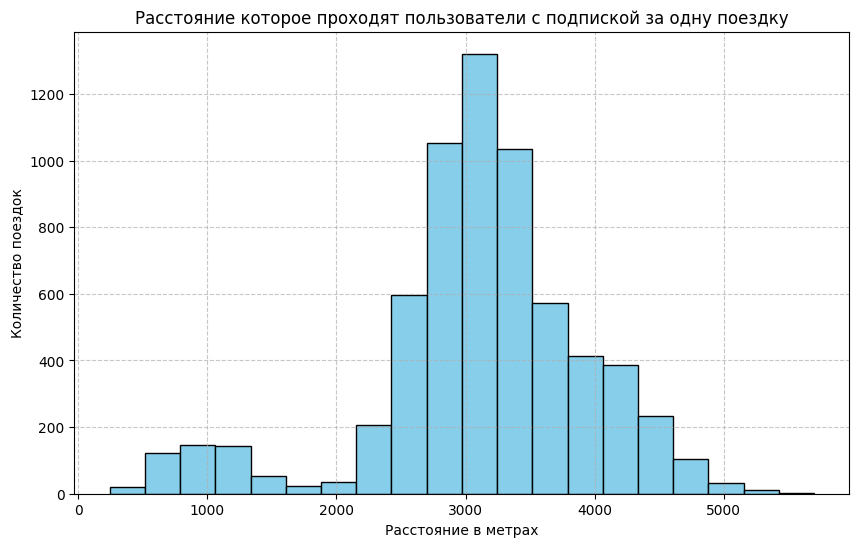

In [77]:
# Построим график пройденных расстояний для пользователей с подпиской и без

ultra['distance'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Расстояние которое проходят пользователи с подпиской за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние в метрах')

plt.show()

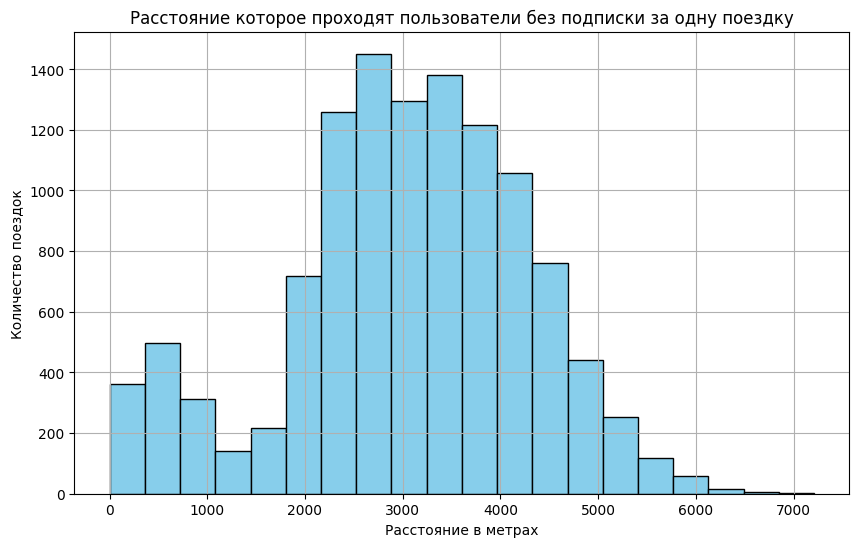

In [78]:
# Построим график пройденных расстояний для пользователей с подпиской и без

free['distance'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.title('Расстояние которое проходят пользователи без подписки за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние в метрах')

plt.show()

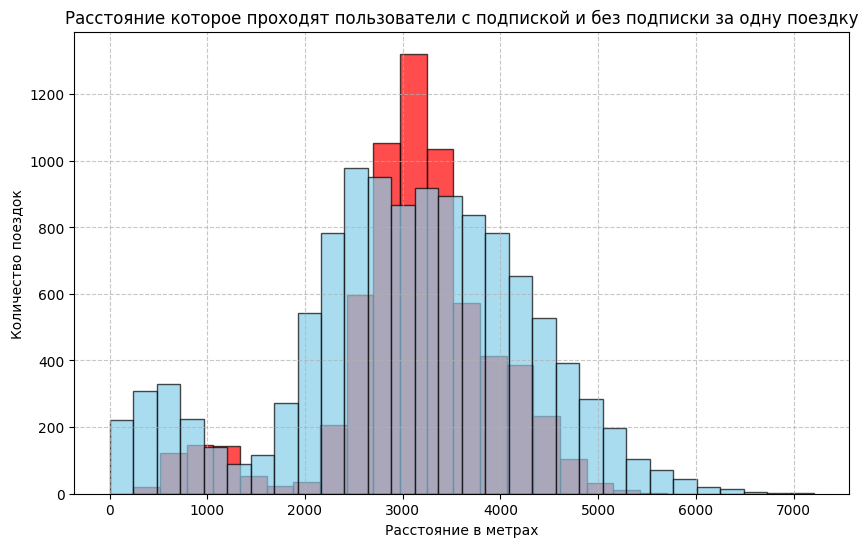

In [79]:
# Построим график пройденных расстояний для пользователей с подпиской и без

ultra['distance'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='red', alpha=0.7)
free['distance'].hist(figsize=(10, 6), bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Расстояние которое проходят пользователи с подпиской и без подписки за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние в метрах')

plt.show()

По графикам пройденного расстояния можно сказать что пользователи с подпиской проезжают за поездку от 2.5 до 3.5 км, пользователи без подписки восносном проезжают от 2 до 5 км за поездку.

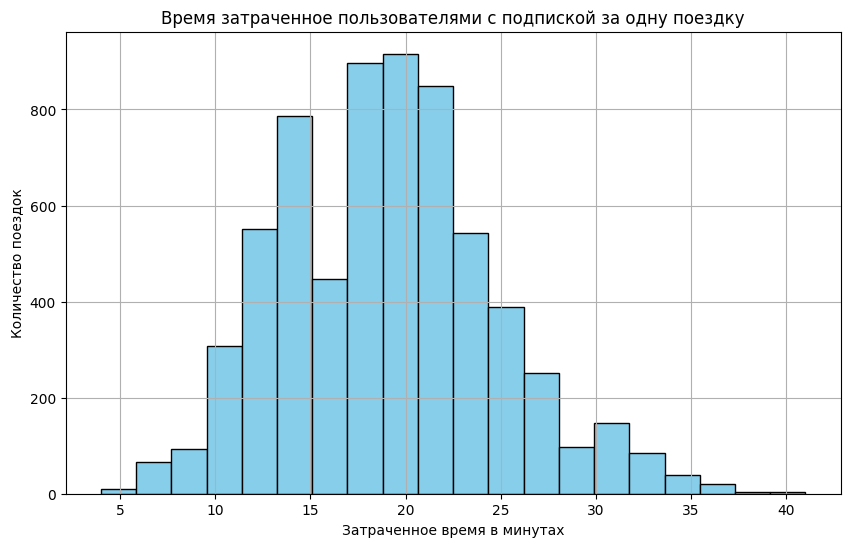

In [80]:
# Построим график пройденных расстояний для пользователей с подпиской и без

ultra[ultra['duration']>0.5]['duration'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.title('Время затраченное пользователями с подпиской за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Затраченное время в минутах')

plt.show()

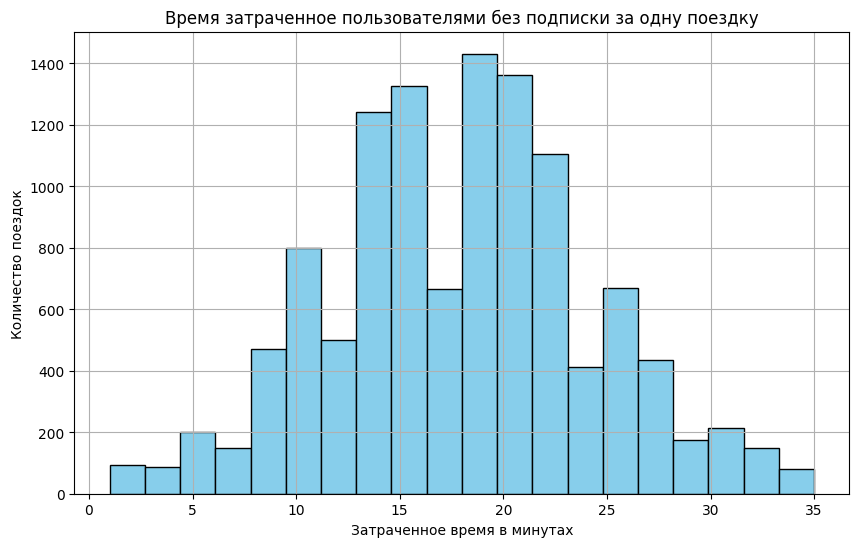

In [81]:
# Построим график пройденных расстояний для пользователей с подпиской и без

free[free['duration']>0.5]['duration'].hist(figsize=(10, 6), bins=20, edgecolor='black', color='skyblue')
plt.title('Время затраченное пользователями без подписки за одну поездку')
plt.ylabel('Количество поездок')
plt.xlabel('Затраченное время в минутах')

plt.show()

По графикам затраченного времени на поезду можно сказать что обе группы пользователей тратят примерно одинаковое время на поездки - основаня масса в интервале от 10 до 25 минут.

### Вывод

Проведенная работа:

- Датафреймы с данными о пользователях, поездках и подписках объединены
- Созданы дополнительно 2 датафрейма с пользователями с подпиской и без
- Визуализирована информация о расстоянии и времени поездок для пользователей обеих категорий

Результаты анализа, проблемы и решения:

По графикам пройденного расстояния можно сказать что пользователи с подпиской проезжают за поездку от 2.5 до 3.5 км, пользователи без подписки восносном проезжают от 2 до 5 км за поездку. По графикам затраченного времени на поезду можно сказать что обе группы пользователей тратят примерно одинаковое время на поездки - основаня масса в интервале от 10 до 25 минут.
Интересно что поездок пользователей без полдписок больше почти в 2 раза чем поездок пользователей с подпиской.

## Шаг 5. Подсчёт выручки

### Аггрегация данных

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [82]:
# Посмотрим первые строки итогового датасета
df.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,"4,409.92",26.00,2021-01-01,1,10.34,Кира,22,Тюмень,ultra,6,0,199
1,1,"2,617.59",16.00,2021-01-18,1,9.93,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7.00,2021-04-20,4,7.26,Кира,22,Тюмень,ultra,6,0,199
3,1,"2,694.78",19.00,2021-08-11,8,8.73,Кира,22,Тюмень,ultra,6,0,199
4,1,"4,028.69",27.00,2021-08-28,8,9.20,Кира,22,Тюмень,ultra,6,0,199


In [83]:
# Сделаем сводную таблицу с аггрегированными данными и переименуем колонки
df_dd = df.pivot_table(index=['month', 
                              'user_id', 
                              'minute_price', 
                              'start_ride_price', 
                              'subscription_fee',
                              'subscription_type'], 
                       values=['distance', 
                               'duration'], 
                       aggfunc={'distance': 'sum', 
                                'duration': 'sum',
                                'user_id': 'count'
    })
df_dd = df_dd.rename(columns={"user_id": "rides"}).reset_index()

In [84]:
# Проверим что все получилось
df_dd.head()

,month,user_id,minute_price,start_ride_price,subscription_fee,subscription_type,distance,duration,rides
0,1,1,6,0,199,ultra,"7,027.51",42.00,2
1,1,3,6,0,199,ultra,"3,061.78",13.00,1
2,1,5,6,0,199,ultra,"3,914.65",13.00,1
3,1,7,6,0,199,ultra,"6,478.08",28.00,2
4,1,12,6,0,199,ultra,"3,577.15",33.00,1


### Рассчет выручки

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. 

In [85]:
# Округлим значения колонку с продолжительностью поездки до ближайшего целого значения вверх
# df_dd['duration'] = np.ceil(df_dd['duration'])

In [86]:
# Проверим что все получилось
df_dd.head()

,month,user_id,minute_price,start_ride_price,subscription_fee,subscription_type,distance,duration,rides
0,1,1,6,0,199,ultra,"7,027.51",42.00,2
1,1,3,6,0,199,ultra,"3,061.78",13.00,1
2,1,5,6,0,199,ultra,"3,914.65",13.00,1
3,1,7,6,0,199,ultra,"6,478.08",28.00,2
4,1,12,6,0,199,ultra,"3,577.15",33.00,1


In [87]:
# Расчитаем выручку для каждого пользователя помесячно
df_dd['revenue'] = df_dd.start_ride_price * df_dd.rides + df_dd.subscription_fee + df_dd.duration * df_dd.minute_price

In [88]:
# Посмотрим что получилось
df_dd.head()

,month,user_id,minute_price,start_ride_price,subscription_fee,subscription_type,distance,duration,rides,revenue
0,1,1,6,0,199,ultra,"7,027.51",42.00,2,451.00
1,1,3,6,0,199,ultra,"3,061.78",13.00,1,277.00
2,1,5,6,0,199,ultra,"3,914.65",13.00,1,277.00
3,1,7,6,0,199,ultra,"6,478.08",28.00,2,367.00
4,1,12,6,0,199,ultra,"3,577.15",33.00,1,397.00


### Вывод

Проведенная работа:

- Создали датафрейм с аггрегированными данными по пройденному растоянию и продолжительностью поездок
- Рассчитали выручку для каждого пользователя помесячно

Результаты анализа, проблемы и решения:

Полученный датафрейм нам пригодится для проверки гипотез.

## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Время пользователей затраченное на поездки

Задача:

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу используя исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Сформулируем гипотезы:

    - H0 - пользовали с подпиской тратят на поездки столько же времени сколько и пользователи без подписок
    - H1 - пользователи с подпиской тратят больше времени на поездки

In [89]:
# Посчитаем среднее время поездки для пользователя с подпиской и без подписки
print('Среднее время поездки пользователя с подпиской', np.mean(df.query("`subscription_fee`!=0")['duration']))
print('Среднее время поездки пользователя без подписки', np.mean(df.query("`subscription_fee`==0")['duration']))

Среднее время поездки пользователя с подпиской 19.037692307692307
Среднее время поездки пользователя без подписки 17.890992392807746


У нас 2 выборки и выборки независимы - будем использовать двухвыброчный t-тест для независимых выборок.

In [90]:
# Выберем уровень статистической значимости
alpha = 0.05

In [91]:
# Рассчитаем результат
# result = st.ttest_ind(
#     df[df["subscription_fee"] != 0]['duration'],
#     df[df["subscription_fee"] == 0]['duration'], 
#     alternative='greater')
result = st.ttest_ind(
    ultra['duration'],
    free['duration'], 
    alternative='greater')


In [92]:
print('p-значение', result.pvalue)

p-значение 2.4959453720736625e-34


In [93]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Отвергаем гипотезу H0 в пользу H1 - пользователи с подпиской тратят больше времени на поездки. Можно сделать вывод о том, что пользователи с подпиской выгоднее для компании.

### Расстояние которое проезжает пользователь за одну поездку

Задача:

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Сформулируем гипотезы:

    - H0 - Пользователи с подпиской в среднем проезжают 3130 метров за одну поездку
    - H1 - Пользователи с подпиской в среднем проезжают больше 3130 метров за одну поездку

In [94]:
# Посчитаем среднее расстояние поездки пользователя с подпиской
print('Среднее расстояние поездки пользователя с подпиской', np.mean(ultra['distance']))

Среднее расстояние поездки пользователя с подпиской 3115.4453880370247


У нас 1 выборкa - будем использовать одновыброчный t-тест

In [95]:
# Предложеннное в нулевой гипотезе число
value = 3130

In [96]:
# Выбранный уровень статистической значимости
alpha = 0.05

In [97]:
# Рассчитаем результат
result = st.ttest_1samp(
    ultra['distance'],
    value, 
    alternative='greater')

In [98]:
print('p-значение', result.pvalue)

p-значение 0.9195368847849785


In [99]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


Отвергнуть гипотезу H0 не удалось - Пользователи с подпиской в среднем проезжают 3130 метров или меньше за одну поездку. Можно сделать вывод о том, что самокаты изнашиваются оптимально.

### Помесячная выручка от пользователя

Задача:

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем гипотезы:

    - H0 - помесячная выручка от пользовалей с подпиской равна помесячной выручке от пользователей без подписки
    - H1 - помесячная выручка от пользовалей с подпиской выше помесячной выручки от пользователей без подписки

In [100]:
# Посчитаем среднее время поездки для пользователя с подпиской и без подписки
print('Средняя помесячная выручка от пользователя с подпиской', np.mean(df_dd.query("`subscription_fee`!=0")['revenue']))
print('Средняя помесячная выручка от пользователя без подписки', np.mean(df_dd.query("`subscription_fee`==0")['revenue']))

Средняя помесячная выручка от пользователя с подпиской 362.7921906022502
Средняя помесячная выручка от пользователя без подписки 328.6413651073845


У нас 2 выборки и выборки независимы - будем использовать двухвыброчный t-тест для независимых выборок.

In [101]:
# Выберем уровень статистической значимости
alpha = 0.05

In [102]:
# Рассчитаем результат
result = st.ttest_ind(
    df_dd.query("`subscription_fee`!=0")['revenue'],
    df_dd.query("`subscription_fee`==0")['revenue'], 
    alternative='greater')

In [103]:
print('p-значение', result.pvalue)

p-значение 1.8850394384715216e-31


In [104]:
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Отвергаем гипотезу H0 в пользу H1 - помесячная выручка от пользовалей с подпиской выше помесячной выручки от пользователей без подписки. Пользователи с подпиской более интересны компании.

### Обращения в техподдержку

Задача:

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для этого задания нам понадобится двухвыборочный t-тест для зависимых выборок. Выбрал этот тест т.к. пользователи остались теже.

### Вывод

Проведенная работа:

- Сформулировали 3 гипотезы для продакт-менеджеров 

Результаты анализа, проблемы и решения:
Пользователи с подпиской выгоднее для компании т.к. совершают более длительные поездки.
Самокаты изнашиваются не оптимально.
Пользователи с подпиской приносят больше прибыли компании чем пользователи без подписки.


## Шаг 7. Распределения

### Раздача промокодов

Условия задачи:

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Подсказка:
Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра 
N для заданного параметра p=0.1 с помощью графиков и метода cdf() , сформулировать вывод и ответ.

In [105]:
# Определим известные параметры
n = 100  # минимальное количество продлений
p = 0.1       # вероятность продления
prob = 0.05  # вероятность не выполнить план

In [106]:
# Поиск минимального N
N = n
while binom.cdf(n - 1, N, p) >= prob:
    N += 1
print("Минимальное количество промокодов для выполнения плана с вероятностью 95%:", N)

Минимальное количество промокодов для выполнения плана с вероятностью 95%: 1161


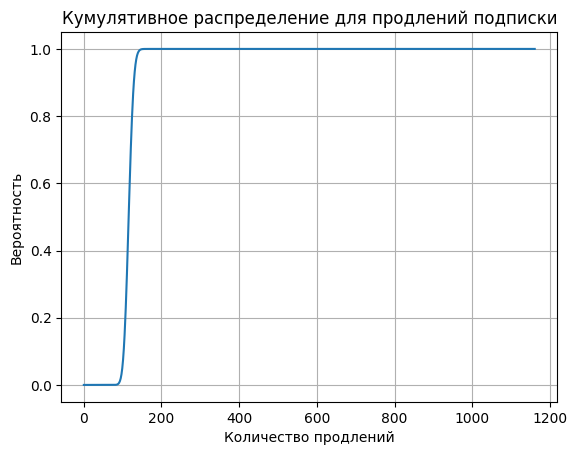

In [107]:
# Построение графика распределения
distr = pd.Series([binom.cdf(k, N, p) for k in range(N+1)])

plt.plot(distr)
plt.title("Кумулятивное распределение для продлений подписки")
plt.xlabel("Количество продлений")
plt.ylabel("Вероятность")
plt.grid(True)
plt.show()

Для выполнени плана нам нужно раздать минимум 1161 промокод, с вероятностью 95% 100 пользователей продлят подписку. 

### Push-уведомления

Условие задачи:

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Подсказка: Эта ситуация тоже описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Вы можете воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

In [108]:
# Определим известные параметры
n = 1000000  # количество разосланных уведомлений
p = 0.40       # вероятность открытия уведомления

In [109]:
# Параметры нормального распределения
mu = n * p  # среднее
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

In [110]:
# Предел для оценки
th = 399500

In [111]:
# Оценка вероятности
prob = norm.cdf(th, mu, sigma)

In [112]:
print(f"Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: {prob:.2f}")

Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: 0.15


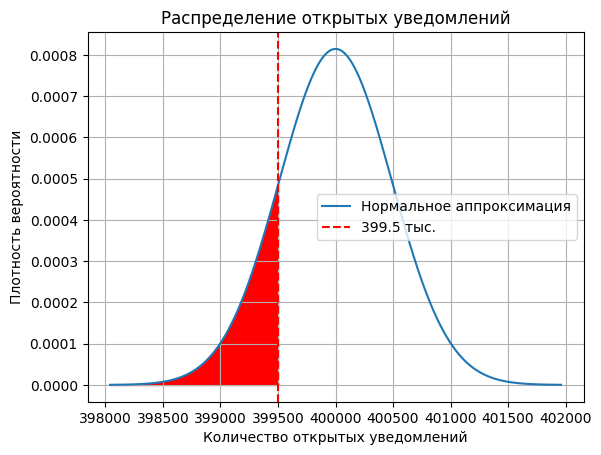

In [113]:
# Построение графика распределения
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, label='Нормальное аппроксимация')
plt.axvline(th, color='red', linestyle='--', label='399.5 тыс.')
plt.fill_between(x, 0, y, where=(x <= th), color='red')
plt.title("Распределение открытых уведомлений")
plt.xlabel("Количество открытых уведомлений")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(True)
plt.show()


Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей при отправке 1 млн уведомлений составляет около 15%.

### Вывод

Проведенная работа:

- Помогли отделу маркетинга оценить вероятность открытия пользователями push-уведомлений и выяснили какое количесвтво промокодов нужно разослать чтобы выполнить план с вероятностью 95%:

Результаты анализа, проблемы и решения:

Для выполнени плана нам нужно раздать минимум 1161 промокод, с вероятностью 95% 100 пользователей продлят подписку. Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей при отправке 1 млн уведомлений составляет около 15%.

## Общий вывод

Что было сделано:

- Открыли файлы с данными и сохранили их в отдельные переменные, посмотрели типы данных в датасетах, построили предварительные графики числовых признаков
- Проверили пропуски, явные и неявные дубликаты
- Построены графики следующих признаков, проведен их анализ:
  - Частота встречаемости городов
  - Cоотношение пользователей с подпиской и без подписки
  - Возраст пользователей
  - Расстояние, которое пользователь преодолел за одну поездку
  - Продолжительность поездок
  - Средняя скорость движении
- Объединили датафреймы с данными о пользователях, поездках и подписках 
- Округлили значение времени поездки до ближайшего целого значения в большую сторону
- Cоздали дополнительно 2 датафрейма с пользователями с подпиской и без
- Визуализировали информация о расстоянии и времени поездок для пользователей обеих категорий
- Создали датафрейм с аггрегированными данными по пройденному растоянию и продолжительностью поездок
- Рассчитали выручку для каждого пользователя помесячно
- Сформулировали и проверили 3 гипотезы для продакт-менеджеров 
- Помогли отделу маркетинга оценить вероятность открытия пользователями push-уведомлений и выяснили какое количесвтво промокодов нужно разослать чтобы выполнить план с вероятностью 95%

Выводы:

- Пропусков в датасетах не обнаружено. Были найдены и удалены явные дубликаты в датасете users. Неявных дубликатов также не было ни в одном датасете.
- Больше всего пользователей пользовались сервисом в Пятигорске, меньше всего в Москве. 54% людей пользуются бесплатной подпиской, остальные платной. Пользователи сервиса - это восновном молодые люди 20-30 лет. Большая часть пользователей совершает поездки на расстояние от 2 до 5 км. Пользователи чаще всего тратят на поездку от 7 до 27 минут. Cредняя скорость за поездку - от 5 до 20 км/ч.
- По графикам пройденного расстояния можно сказать что пользователи с подпиской проезжают за поездку от 2.5 до 3.5 км, пользователи без подписки восносном проезжают от 2 до 5 км за поездку. По графикам затраченного времени на поезду можно сказать что обе группы пользователей тратят примерно одинаковое время на поездки - основаня масса в интервале от 10 до 25 минут. Интересно что поездок пользователей без полдписок больше почти в 2 раза чем поездок пользователей с подпиской.
- Пользователи с подпиской выгоднее для компании т.к. совершают более длительные поездки.
- Самокаты изнашиваются оптимально.
- Пользователи с подпиской приносят больше прибыли компании чем пользователи без подписки.
- Для выполнени плана отделу маркетинга нужно раздать минимум 1161 промокод, с вероятностью 95% 100 пользователей продлят подписку. 
- Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей при отправке 1 млн уведомлений составляет около 15%.